# Regulome Explorer  Fisher's exact test for categorical features
Check out more notebooks at our ['Regulome Explorer Repository'](https://github.com/isb-cgc/Community-Notebooks/tree/master/RegulomeExplorer)!

In this notebook we describe how Regulome Explorer uses the Fisher's exact test to compute the significance of associations between two categorical features. This test is used by Regulome Explorer when both features have only two categories, such as the presence or absence of Somatic mutations or the gender of the participants. 

To describe the implementation, we will use Somatic mutation data for two user defined genes. This data is read from a BigQuery table in the pancancer-atlas dataset. For reference, a description of the Fisher's exact can be found in the following link: http://mathworld.wolfram.com/FishersExactTest.html

## Authenticate with Google  (IMPORTANT)
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

#### Import Python libraries

In [14]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import re_module.bq_functions as regulome

## Userdefined Parameters
The parameters for this experiment are the cancer type, the name of gene1 and the name of gene2 for which mutation information will be extracted.  

In [15]:
cancer_type = 'PAAD'
mutation_name1 = 'KRAS'
mutation_name2 = 'TP53'
MinSampleSize = 10

bqclient = bigquery.Client()

## Data from BigQuery tables

The first step is to select all participants in the selected study with a least one mutation.

In [3]:
barcode_set = """barcodes AS (
   SELECT bcr_patient_barcode AS ParticipantBarcode   
   FROM `pancancer-atlas.Filtered.clinical_PANCAN_patient_with_followup_filtered`
   WHERE acronym = '{0}'       
)
""".format(cancer_type)

Somatic mutation data for gene 1. The following string query will retrieve a table with patients with at least one Somatic mutation in the user defined gene ('mutation_name'). This information is extracted from the 'pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample' table, available in pancancer-atlas dataset. Notice that we only use samples in which FILTER = 'PASS'. 

In [4]:
query_table1 = """table1 AS (
SELECT   
   t1.ParticipantBarcode, 
   IF( t2.ParticipantBarcode is null, 'NO', 'YES') as data
FROM
   barcodes AS t1
LEFT JOIN   
   (
   SELECT
      ParticipantBarcode AS ParticipantBarcode
   FROM `pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample`
   WHERE Study = '{0}' AND Hugo_Symbol = '{1}'
         AND FILTER = 'PASS'  
   GROUP BY ParticipantBarcode
   ) AS t2
ON t1.ParticipantBarcode = t2.ParticipantBarcode
)
""".format(cancer_type, mutation_name1)

The Somatic mutation data for gene 2 is retrieved using a similar query:

In [5]:
query_table2 = """table2 AS (
SELECT   
   t1.ParticipantBarcode, 
   IF( t2.ParticipantBarcode is null, 'NO', 'YES') as data
FROM
   barcodes AS t1
LEFT JOIN   
   (
   SELECT
      ParticipantBarcode AS ParticipantBarcode
   FROM `pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample`
   WHERE Study = '{0}' AND Hugo_Symbol = '{1}'
         AND FILTER = 'PASS'  
   GROUP BY ParticipantBarcode
   ) AS t2
ON t1.ParticipantBarcode = t2.ParticipantBarcode
)
""".format(cancer_type, mutation_name2)

The following query combines the two tables based on Participant barcodes. Nij is the number of participants for each pair of categories. data1 (data2) column is the Somatic Mutations for gene1 (gene2). 'YES' for pariticpants with mutation and 'NO' otherwise.   

In [16]:
query_summarize = """summ_table AS (
SELECT 
   n1.data as data1,
   n2.data as data2,
   COUNT(*) as Nij
FROM
   table1 AS n1
INNER JOIN
   table2 AS n2
ON
   n1.ParticipantBarcode = n2.ParticipantBarcode
GROUP BY
  data1, data2
) 
""".format(str(MinSampleSize) )

At this point we can take a look at output table, where the column **Nij** is the number of participants for each pair of categorical values.

In [7]:
sql_data = 'WITH\n' + barcode_set+','+query_table1+','+query_table2+','+query_summarize 

sql = (sql_data + '\n' +
"""SELECT * FROM summ_table 
   ORDER BY  data1
""")

df_data = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_data


 in runQuery ... 
    the results for this query were previously cached 


,data1,data2,Nij
0,NO,NO,50
1,NO,YES,17
2,YES,YES,90
3,YES,NO,27


We can use a 'catplot' to visualize the populations in each category. 

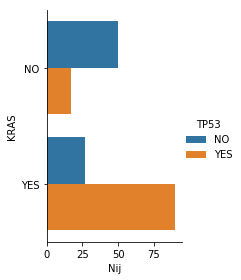

In [8]:
df_data.rename(columns={ "data1": mutation_name1, "data2": mutation_name2 }, inplace=True)
sns.catplot(y=mutation_name1, x="Nij",hue=mutation_name2,data=df_data, kind="bar",height=4, aspect=.7)

##  Compute the statistics 
After sumarizing the data in the table above, we are in the position to perform the 2-sided Fisher's Exact test for the null hypothesis that no nonrandom associations exist between the two categorical variables (Somatic mutations). For clarity we consider the following 2x2 contingency table.

|-         |-     |Gene2|    |
|:--       |:-- |:--- |:---|
|-         |-    |YES  |NO  |
|**Gene1** |YES |$a$    |$b$   |
|-          |NO  |$c$    |$d$   | 

To compute the p-Value of the Fisher's test, we need to compute the Hypergeometric distribution:

$$Pr(x) = \frac{(a+b)!(c+d)!(a+c)!(b+d)! }{x!(a+b-x)!(a+c-x)!(d-a+x)!n!} $$

Where $n=a+b+c+d$. The p-Value is then computed by:

$$p_{FET}(a,b,c,d) = \sum_{x} Pr(x) \ I\left[ Pr(x) \leq Pr(a) \right]  $$

Efficient computation of  $p_{FET}$ using BigQuery commands would be very difficult due to the factorials. Instead we take advantage of the possibility of implementing User-Defined Functions using JavaScript. The following string contains a JavaScript function (pFisherExact) that computes $p_{FET}$.
 

In [9]:
query_expected="""
CREATE TEMP FUNCTION pFisherExact(a FLOAT64, b FLOAT64, c FLOAT64, d FLOAT64)
RETURNS FLOAT64
LANGUAGE js AS \"\"\"
  function LnHyperGeometric( a_LnF, a, b, c, d) {
      return  a_LnF[a+b] + a_LnF[c+d] + a_LnF[a+c] + a_LnF[b+d] - a_LnF[a] - a_LnF[b] - a_LnF[c] - a_LnF[d] - a_LnF[a + b + c + d]  
  }
  
  var n = Math.round(a + b + c + d);
  var LnFact = Array(n).fill(0);
  
  for (i = 1; i <= n; i++) {
     LnFact[i] = LnFact[i-1] + Math.log(i)  ;
  }
  
  var LnPra = LnHyperGeometric( LnFact, a, b, c, d) ;
  var temp = 0
  
  for (x = 1; x <= n; x++) {
     if ( ( a+b-x >= 0 ) && ( a+c-x >= 0 ) && ( d-a+x >= 0 ) ) {
        var LnPrx = LnHyperGeometric( LnFact, x , a+b-x, a+c-x, d-a+x) ;
      
        if ( LnPrx <= LnPra ) { 
            temp = temp + Math.exp( LnPrx - LnPra );
        }         
     }
  }
  
  var LnPFET = LnPra  + Math.log( temp );
  return  Math.exp( LnPFET ) ;
\"\"\";
"""


The following BigQuery string computes $a$, $b$, $c$, and $d$ as indicated above and then uses our JavaScrip function to compute the p-Value of the Fisher exact test.  

In [10]:
query_fishertest = """
SELECT a,b,c,d,
       pFisherExact(a,b,c,d) as pValue
FROM (
SELECT 
  MAX( IF( (data1='YES') AND (data2='YES'), Nij, NULL ) ) as a ,
  MAX( IF( (data1='YES') AND (data2='NO') , Nij, NULL ) ) as b ,
  MAX( IF( (data1='NO') AND (data2='YES') , Nij, NULL ) ) as c ,
  MAX( IF( (data1='NO') AND (data2='NO')  , Nij, NULL ) )  as d 
FROM summ_table 
)
WHERE a IS NOT NULL AND b IS NOT NULL AND c IS NOT NULL AND d IS NOT NULL 
"""

sql = ( query_expected  + sql_data +  query_fishertest )
df_results = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_results


 in runQuery ... 
    this query processed 71183110 bytes 
    Approx. elpased time : 2775 miliseconds 


,a,b,c,d,pValue
0,90,27,17,50,8.046829e-12


To test our implementation we can use the 'fisher_exact' function available in python

In [17]:
a = df_results['a'][0]
b = df_results['b'][0]
c = df_results['c'][0]
d = df_results['d'][0]

oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]])
pvalue

8.046828829097227e-12